# <center>Мобильная игра Cookie cats: A/B test </center>

<div style="text-align: center;">
  <img src="https://play-lh.googleusercontent.com/KBXHx65Nj_NOGRbqWSQUqKbsR0dpDV1X1jB4EPABF700t6SjvJkNEjaVaANNoPzH82Fx=w832-h470"
       alt="A/B test"
       width="1000">
</div>

## Содержание

1. **[Background проекта](#1)**
2. **[Описание данных](#2)**
3. **[Предобработка данных](#3)**
4. **[Анализ пользовательского поведения](#4)**
5. **[Сравнение 1-day и 7-day retention](#5)**
6. **[Выводы](#6)**

## 1. Background проекта <a name= '1'></a>

Cookie Cats — это популярная мобильная казуальная игра-головоломка ("3 в ряд") от студии Tactile Games. Суть игры в том, что игроки соединяют элементы (печеньки, фрукты и др.), чтобы очистить игровую доску и продвинуться по сюжету. На определённых уровнях перед игроком появляется "гейт" — барьер, который нужно преодолеть, чтобы продолжить игру. Чтобы преодолеть барьер нужно либо подождать определенное время, либо совершить внутриигровую покупку, значительно ускорив процесс. В ходе проведения A/B теста сравнивается два варианта размещения "гейта" (на уровнях 30 и 40) и анализируется, как это влияет на активность и удержание игроков.

**Задача:** проанализировать результат A/B-теста в мобильной игре Cookie Cats. Необходимо понять, влияет ли изменение сложности (уровень размещения "гейта") на поведение пользователей и удержание игроков. 

**Метрики для сравнения:** 1-day retention и 7-day retention пользователей после установки игры.

**План работы:** 
1. Загрузка данных
2. Предобработка данных
   - проверка на наличие пропущенных значений
   - проверка на наличие дубликатов
   - проверка на наличие выбросов
3. Анализ поведения игроков
4. Сравнение 1-day retention и 7-day retention
5. Выводы

## 2. Описание данных <a name= '2'></a>

Набор данных содержит информацию по 90 189 игрокам, установившим игру во время проведения A/B-теста. Каждый игрок рандомно попал либо в контрольную группу ("гейт" на уровне 30), либо в тестовую ("гейт" на уровне 40). Датасет содержит следующие столбцы:

- userid — уникальный идентификатор каждого игрока

- version — группа A/B-теста: gate_30 (контрольная) и gate_40 (тестовая)

- sum_gamerounds — количество сыгранных раундов за первую неделю после установки

- retention_1 — вернулся ли игрок и сыграл хотя бы один раунд на следующий день после установки (1-day retention)

- retention_7 — вернулся ли игрок и сыграл хотя бы один раунд через семь дней после установки (7-day retention)

## 3. Предобработка данных <a name= '3'></a>

#### 3.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 3.2 Загрузка данных

In [2]:
df = pd.read_csv(r'D:\pet_projects\cookie_cats_AB_test\cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### 3.3 Первичный анализ данных

In [3]:
def check_df(dataframe, head=5, tail=5, describe=True):
    # Shape
    print(" SHAPE ".center(70, '-'))
    print(f"Rows: {dataframe.shape[0]:,}")
    print(f"Columns: {dataframe.shape[1]:,}")
    
    # Types
    print(" TYPES ".center(70, '-'))
    print(dataframe.dtypes)
    
    # Head
    print(" HEAD ".center(70, '-'))
    print(dataframe.head(head))
    
    # Tail
    print(" TAIL ".center(70, '-'))
    print(dataframe.tail(tail))
    
    # Missing values
    print(" MISSING VALUES ".center(70, '-'))
    missing = dataframe.isnull().sum()
    missing_percent = (missing / len(dataframe) * 100).round(2)
    missing_info = pd.DataFrame({
        'missing_count': missing,
        'missing_percent': missing_percent
    })
    print(missing_info[missing_info['missing_count'] > 0] if missing_info.sum().sum() > 0 else "No missing values")
    
    # Duplicates
    print(" DUPLICATED VALUES ".center(70, '-'))
    print(f"{dataframe.duplicated().sum()} duplicated rows")
    
    # Categorical variables overview
    cat_cols = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols:
        print(" CATEGORICAL VARIABLES ".center(70, '-'))
        for col in cat_cols:
            print(f"{col}: {dataframe[col].nunique()} unique values → {dataframe[col].unique()[:10]}")
    else:
        print("No categorical columns detected.")
    
    # Numeric summary
    if describe:
        print(" DESCRIBE ".center(70, '-'))
        print(dataframe.describe(percentiles=np.arange(0, 1.1, 0.1)).T)

In [4]:
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 90,189
Columns: 5
------------------------------- TYPES --------------------------------
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
-------------------------------- HEAD --------------------------------
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
-------------------------------- TAIL --------------------------------
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False   

**Выводы:**
1. В датасете отсутствуют пропущенные значения.
2. В датасете отсутствуют дублирущие значения.
3. Судя по процентилям в столбце sum_gamerounds присутствуют выбросы в большую сторону (игроки, прошедшие очень большое количество уровней за неделю).

#### 3.4 Проверка баланса групп

In [5]:
# Количество и процент игроков по группам gate_30 и gate_40
group_counts = df.groupby('version')['userid'].nunique().reset_index()
group_counts.columns = ['version', 'players']
group_counts['percent'] = round(group_counts['players'] / group_counts['players'].sum() * 100, 2)
print("Баланс по группам:")
print(group_counts)

Баланс по группам:
   version  players  percent
0  gate_30    44700    49.56
1  gate_40    45489    50.44


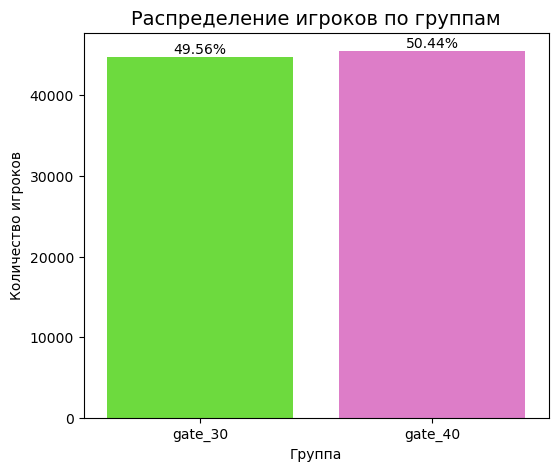

In [6]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=group_counts,
    x='version', 
    y='players',
    hue='version',
    palette = ['#63F424', '#ED6DD1']
)
plt.title("Распределение игроков по группам", fontsize=14)
plt.ylabel("Количество игроков")
plt.xlabel("Группа")

# Добавим подписи значений на столбцах
for i, row in group_counts.iterrows():
    plt.text(i, row['players'] + 500, f"{row['percent']}%", ha='center', fontsize=10)
# group_counts.iterrows() — проходим по строкам таблицы. plt.text(...) — добавляем текст над каждым столбиком:
# i — позиция по X.
# row['players'] + 500 — чуть выше вершины столбика (чтобы текст не налезал).
# f"{row['percent']}%" — сам текст (процент).
# ha='center' — выравниваем по центру.
plt.show()

**Вывод:** 

Как видно из диаграммы, в датасете представлено сбалансированное количество игроков в группах. Оказалось, что примерно 49.6% игроков попало в gate_30 и 50.4% — в gate_40. Это почти равное распределение (практически 50/50). Это означает, что любые выявленные далее различия в поведении игроков можно с большой вероятностью приписать именно разнице в уровне "гейта", а не дисбалансу в размере групп. 

#### 3.5 Проверка наличия выбросов

In [7]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


In [8]:
df.groupby('sum_gamerounds')['userid'].count()

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

В столбце sum_gamerounds присутствую выбросы в большую сторону (игроки, прошедшие большое количество уровней). Об этом свидетельствует следующее:

- Медиана количества сыгранных раундов составляет всего 16, а 80-й перцентиль — 67 раундов.
- Максимальное значение достигает почти 49 854 раундов, что радикально отличается от основной массы данных.
- Начиная с 99-го перцентиля (493 раунда) наблюдаются крайне редкие значения (тысячи сыгранных раундов).

Наличие очень больших значений sum_gamerounds можно объяснить несколькими причинами:

1. Игровые фанаты (power users), стремящиеся быстро пройти игру или соревноваться в рейтингах.
2. Автоматизированная активность / боты
3. Технические ошибки сбора данных (некорректная работа логирования, дубли событий или некорректное время синхронизации могут «накапливать» лишние сессии в данных).

Для дальнейшего корректного анализа удалим выбросы (самые экстремальные значения), лежащие за пределами 1-го и 99-го процентилей.

In [9]:
def handle_outliers(dataframe, column, lower_pct=0.01, upper_pct=0.99, visualize=False):
    """
    Функция для удаления выбросов.

    Параметры:
        dataframe : pd.DataFrame — исходный датасет
        column : str — имя числовой колонки
        lower_pct : float — нижний перцентиль (по умолчанию 0.01)
        upper_pct : float — верхний перцентиль (по умолчанию 0.99)
        visualize : bool — рисовать ли boxplot до/после

    Возвращает:
        pd.DataFrame — датафрейм без выбросов
    """

    q_low = dataframe[column].quantile(lower_pct)
    q_high = dataframe[column].quantile(upper_pct)
    iqr = q_high - q_low
    lower = q_low - 1.5 * iqr
    upper = q_high + 1.5 * iqr

    df_clean = dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)].copy()

    print(f'Удалено выбросов: {len(dataframe) - len(df_clean)}')
    print(f'Новый размер датасета: {df_clean.shape}')

    if visualize:
        plt.figure(figsize=(14, 5))

        # До очистки
        plt.subplot(1, 2, 1)
        sns.boxplot(x=dataframe[column], color='#63F424')
        plt.title(f'До удаления выбросов: {column}')
        plt.grid(True, alpha=0.3)

        # После очистки
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_clean[column], color='#63F424')
        plt.title(f'После удаления выбросов: {column}')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return df_clean

Удалено выбросов: 61
Новый размер датасета: (90128, 5)


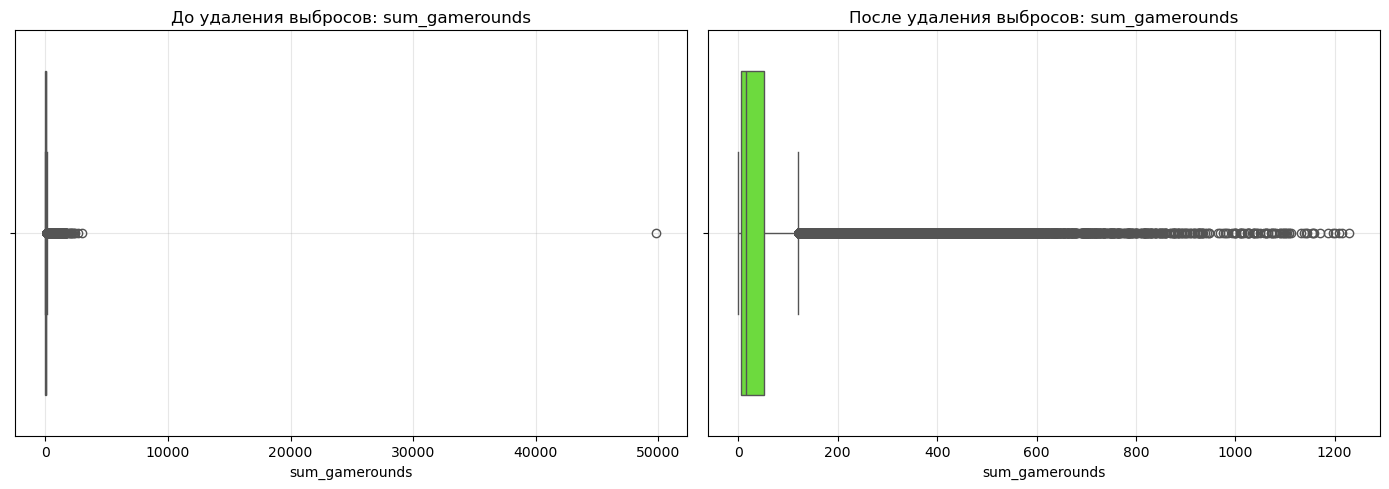

In [10]:
df_cleaned = handle_outliers(df, 'sum_gamerounds', visualize=True)

In [11]:
df_cleaned.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90128.0,50.309637,94.468697,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,219.0,478.0,1230.0


In [12]:
df_cleaned.groupby('sum_gamerounds')['userid'].count()

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
1196       1
1200       1
1209       1
1215       1
1230       1
Name: userid, Length: 885, dtype: int64

## 4. Анализ пользовательского поведения <a name= '4'></a>

#### 4.1 Распределение количества сыгранных раундов

In [13]:
df_cleaned.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90128.0,50.309637,94.468697,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,219.0,478.0,1230.0


In [14]:
both_gate_rounds = df_cleaned.groupby('sum_gamerounds')['userid'].count().reset_index()
both_gate_rounds.head(15)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


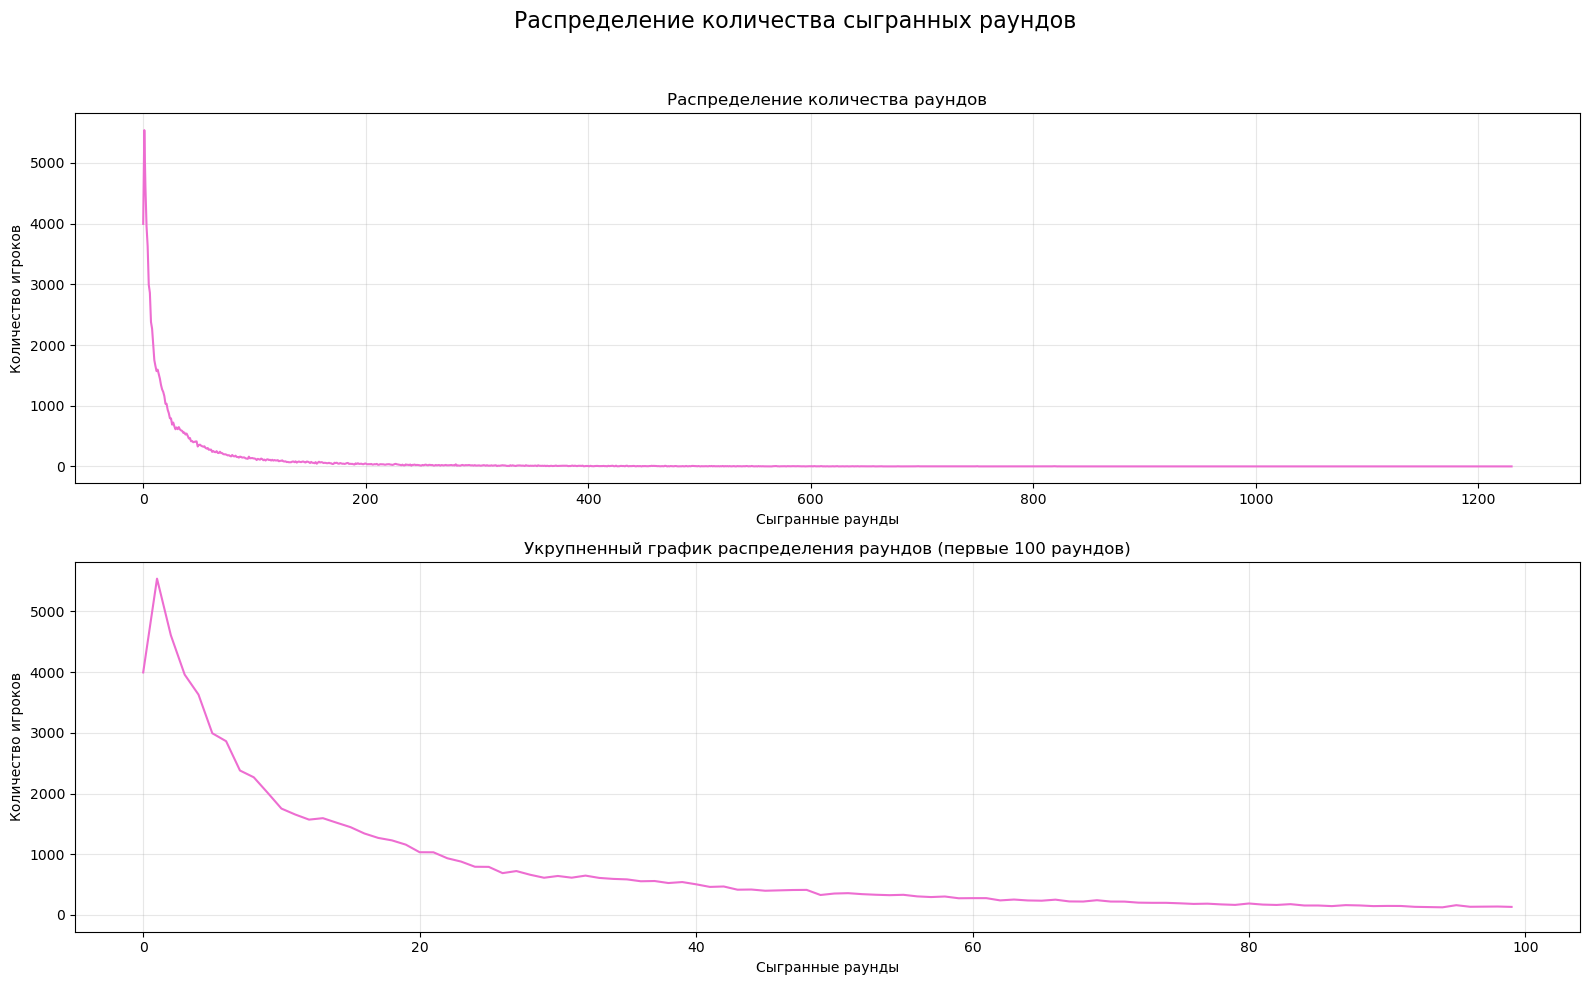

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

# Полный график распределения
sns.lineplot(data=both_gate_rounds, x='sum_gamerounds', y='userid', ax=axes[0], color = '#ED6DD1')
axes[0].set_title('Распределение количества раундов')
axes[0].set_xlabel('Сыгранные раунды')
axes[0].set_ylabel('Количество игроков')
axes[0].grid(True, alpha=0.3)

# Укрупненный график распределения (первые 100 раундов)
sns.lineplot(data=both_gate_rounds[:100], x='sum_gamerounds', y='userid', ax=axes[1], color = '#ED6DD1')
axes[1].set_title('Укрупненный график распределения раундов (первые 100 раундов)')
axes[1].set_xlabel('Сыгранные раунды')
axes[1].set_ylabel('Количество игроков')
axes[1].grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение количества сыгранных раундов', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

График распределения числа сыгранных раундов (sum_gamerounds) имеет правостороннюю ассиметрию. Это означает, что большинство игроков прошли сравнитеьлно мало уровней в первую неделю после установки игры:

- 50% пользователей прошло 16 уровней в первую неделю после установки
- 90% пользователей прошло 134 уровня в первую неделю после установки

Важно отметить, что 3994 игроков (4.5% пользователей) не прошли ни один уровень. Это может обяснятся следующим:

- Пользователю не понравилась игра "с первого взгляда" (из-за дизайна/музыки/сюжета)
- Пользователь не понял, как играть (стоит удостовериться, что в игре есть хотя бы минимальное обучение)
- У пользователя не было времени поиграть

Компании разработчиков Tactile Games имеет смысл выявить причины оттока пользователей.

#### 4.2 Распределение количества сыгранных раундов по группам gate_30 и gate_40

In [16]:
print("Статистика по количеству сыгранных раундов:")
df_cleaned.groupby('version')['sum_gamerounds'].describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])

Статистика по количеству сыгранных раундов:


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
version,,,,,,,,,,,,,,
gate_30,44670.0,50.360040,93.970748,0.0,0.0,1.0,1.0,4.0,17.0,66.0,135.0,220.0,480.31,1209.0
gate_40,45458.0,50.260108,94.956478,0.0,0.0,1.0,1.0,3.0,16.0,68.0,133.0,218.0,476.00,1230.0


In [17]:
gate_30_rounds = df_cleaned[df_cleaned['version'] == 'gate_30'].groupby('sum_gamerounds')['userid'].count().reset_index()
gate_40_rounds = df_cleaned[df_cleaned['version'] == 'gate_40'].groupby('sum_gamerounds')['userid'].count().reset_index()

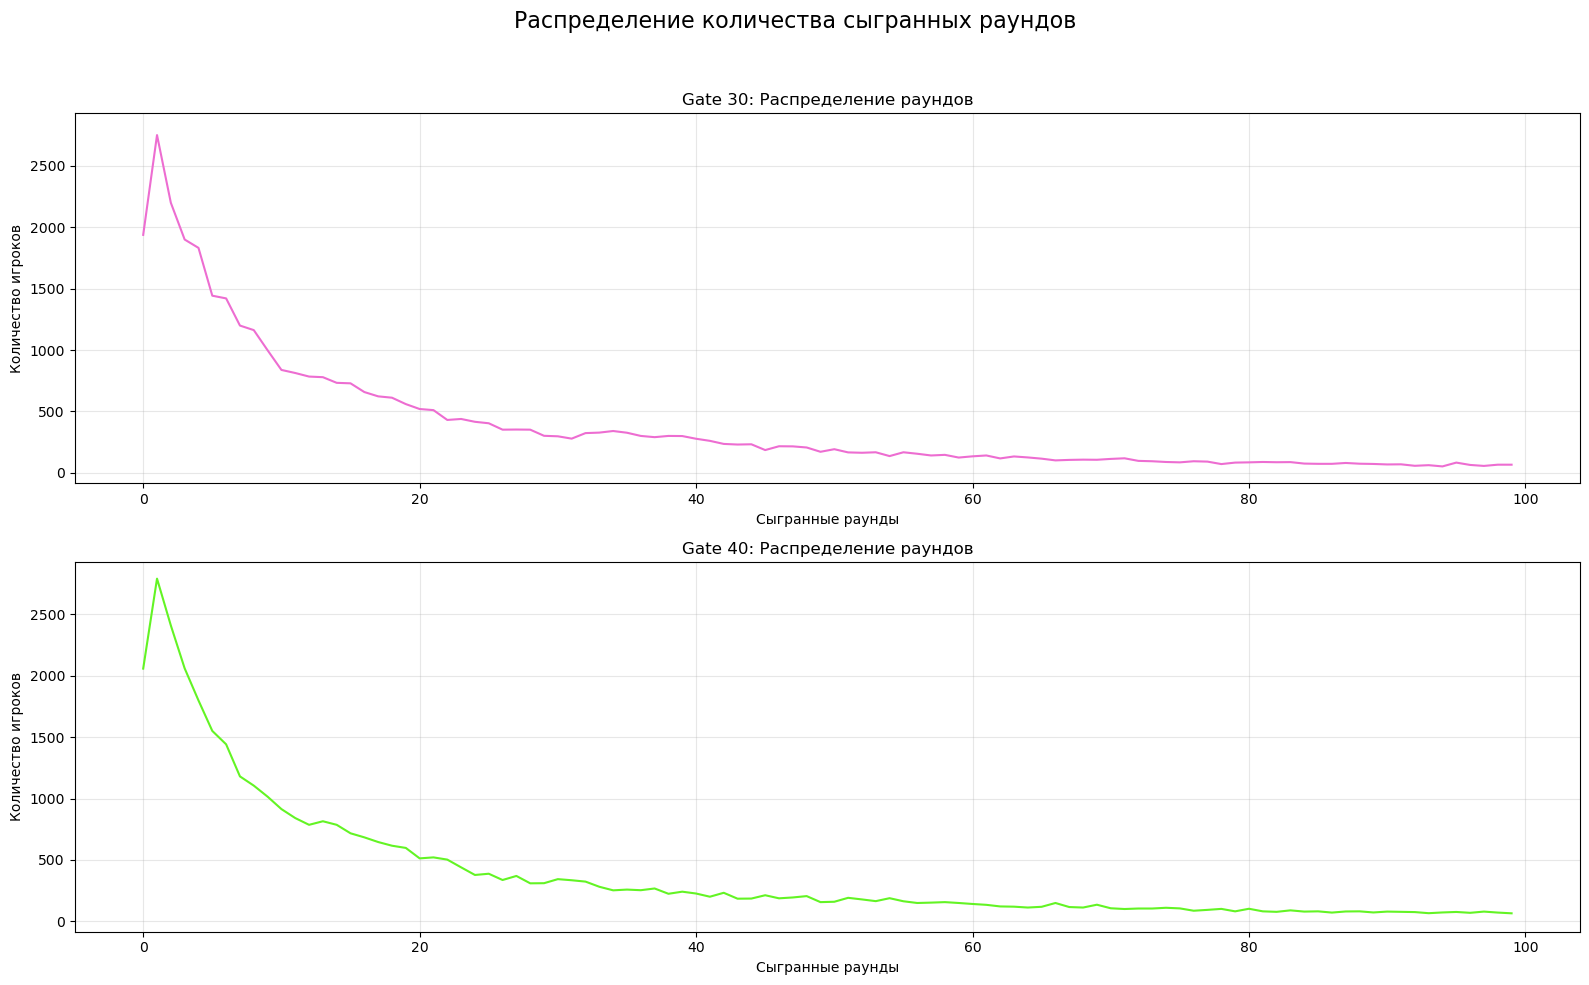

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

# График для gate_30
sns.lineplot(data=gate_30_rounds[:100], x='sum_gamerounds', y='userid', ax=axes[0], color = '#ED6DD1')
axes[0].set_title('Gate 30: Распределение раундов')
axes[0].set_xlabel('Сыгранные раунды')
axes[0].set_ylabel('Количество игроков')
axes[0].grid(True, alpha=0.3)

# График для gate_40
sns.lineplot(data=gate_40_rounds[:100], x='sum_gamerounds', y='userid', ax=axes[1], color = '#63F424')
axes[1].set_title('Gate 40: Распределение раундов')
axes[1].set_xlabel('Сыгранные раунды')
axes[1].set_ylabel('Количество игроков')
axes[1].grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение количества сыгранных раундов', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Вывод:**

Распределение активности игроков по количеству пройденных уровней совпадает в обеих группах. Это означает, что повышение уровня гейта до 40 не заставило игроков играть значительно меньше или больше раундов в первую неделю после установки.

## 5. Сравнение 1-day и 7-day retention <a name= '5'></a>

#### 5.1 Сравнение retention по группам

In [19]:
# Считаем среднее retention_1 и retention_7 по группам
retention_1 = df_cleaned.groupby('version')['retention_1'].mean().reset_index()
retention_7 = df_cleaned.groupby('version')['retention_7'].mean().reset_index()
print(f'Средние значения 1-day retention:\n{retention_1}\n')
print(f'Средние значения 7-day retention:\n{retention_7}')

Средние значения 1-day retention:
   version  retention_1
0  gate_30     0.447840
1  gate_40     0.441924

Средние значения 7-day retention:
   version  retention_7
0  gate_30     0.189657
1  gate_40     0.181464


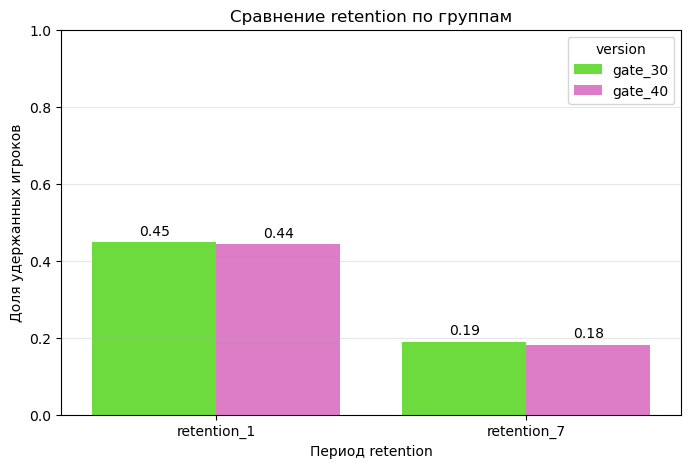

In [20]:
# Подготовка данных
retention_melted = df_cleaned.melt(
    id_vars='version', # идентификатор группы
    value_vars=['retention_1', 'retention_7'], # колонки, которые мы собираем в одну
    var_name='retention_period', # имя новой колонки, в которой будет храниться название периода (1 или 7)
    value_name='retention'  # имя новой колонки, в которой будет храниться значение удержания (0 или 1)
)

# Построение диаграммы
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=retention_melted, x='retention_period', y='retention', hue='version', palette = ['#63F424', '#ED6DD1'], errorbar=None)
plt.title('Сравнение retention по группам')
plt.ylabel('Доля удержанных игроков')
plt.xlabel('Период retention')
plt.ylim(0, 1)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем подписи над столбиками
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)
plt.show()

#### 5.2 Статистическая проверка гипотез

1. Н0: Средний уровень 1-day retention не отличается в зависимости от группы\
   Н1: Средний уровень 1-day retention различается в зависимости от группы
     
2. Н0: Средний уровень 7-day retention не отличается в зависимости от группы\
   Н1: Средний уровень 7-day retention различается в зависимости от группы

In [21]:
from statsmodels.stats.proportion import proportions_ztest

# Функция для 
def ab_test_proportion(df, metric):
    # Подсчёт вернувшихся игроков
    successes = np.array([
        df[df['version'] == 'gate_30'][metric].sum(),
        df[df['version'] == 'gate_40'][metric].sum()
    ])
    
    # Общее количество игроков в каждой группе
    nobs = np.array([
        df[df['version'] == 'gate_30'][metric].count(),
        df[df['version'] == 'gate_40'][metric].count()
    ])
    
    # Запуск Z-теста
    stat, pval = proportions_ztest(successes, nobs)
    
    print(f'Результаты A/B теста для {metric}:')
    print(f'  Z-статистика = {stat:.4f}')
    print(f'  p-value = {pval:.4f}')
    if pval < 0.05:
        print('  Разница статистически значима (отвергаем H0)')
    else:
        print('  Нет статистически значимой разницы (не отвергаем H0)')
    print('-'*50)


In [22]:
# Проверяем обе метрики
ab_test_proportion(df_cleaned, 'retention_1')
ab_test_proportion(df_cleaned, 'retention_7')

Результаты A/B теста для retention_1:
  Z-статистика = 1.7867
  p-value = 0.0740
  Нет статистически значимой разницы (не отвергаем H0)
--------------------------------------------------
Результаты A/B теста для retention_7:
  Z-статистика = 3.1637
  p-value = 0.0016
  Разница статистически значима (отвергаем H0)
--------------------------------------------------


## 6. Выводы <a name= '6'></a>

В данной работе стояла следующая задача - проанализировать результат A/B-теста в мобильной игре Cookie Cats и понять, влияет ли изменение сложности (уровень размещения "гейта") на поведение пользователей и удержание игроков.

Резюмируя, повышение уровня гейта с 30 до 40 не принесло существенного улучшения метрик. Влияние на количество сыгранных раундов и удержание игроков минимально. Однако, наблюдается небольшое ухудшение 7-day retention.

- Рекомендуется оставить гейт на уровне 30, так как усложнение игры (перенос гейта на 40 уровень) не оправдывает себя ни с точки зрения удержания, ни с точки зрения повышения активности игроков.

Помимо основной задачи был выявлен существенный отток пользователей на ранних этапах игры (с 1 по 20 уровни). Потенциальные причины оттока могут быть связаны с неудобным интерфейсом, отсутствием обучения или неинтересном геймплее.
- Рекомендуется провести дополнительное исследование по выявлению причин оттока игроков на ранней стадии игры.